Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_0km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
size of cropped image: (6000, 228, 227)
size of cross_corr image: (228, 227)
1 pixel equals to 0.011013215859030838 meters
 
time:  104.14024602900001


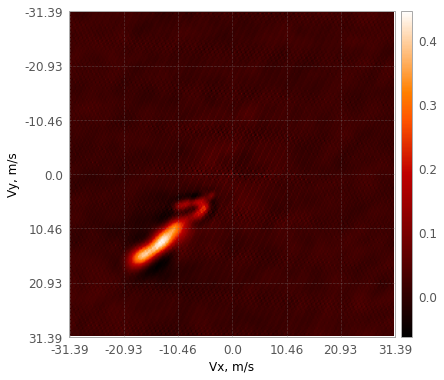

In [1]:
from data_processing import data_processing   

D         = 2.5                   # диаметр телескопа, [м]
latency   = 4                     # временная задержка в кросс-корреляции, [кол-во кадров] 
file_bias = "bias20210130.fits"
file      = "20210130l_0km.fits"  # "20210130l_m2km.fits"

# kadr_num  = 0                     # номер кадра для отображения на графиках

data_processing(file, file_bias, D, latency) 